In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import scipy.integrate as integrate
from scipy.stats import norm
# to print plots inline
%matplotlib inline

## Problem 1

The first step is to discretize the shocks z and turn the AR(1) process into a Markov process and find the transition probabilities.

In [2]:
# set out parameters
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu

# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
z_grid=np.exp(z_grid)
print('Grid points = ', z_grid)

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]


Grid points =  [ 0.57170087  0.72611947  0.82344962  0.91128377  1.          1.09735302
  1.21440337  1.37718384  1.74916648]


In [3]:
import time

# specify parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
betafirm = (1 / (1 + r))

In [4]:
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [5]:
# firm cash flow, e
@jit
def e(z_grid):
    e = np.zeros((len(z_grid),sizek, sizek))
    for h in range(len(z_grid)):
        op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *\
          ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) *\
          (z_grid[h] ** (1 / (1 - alpha_l)))
        for i in range(sizek):
            for j in range(sizek):
                    e[h, i, j] = (op[i] - kvec[j] + ((1 - delta) * kvec[i]) -
                               ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                                / kvec[i]))
    return e

@jit
def find_vmat(V,ez,sizek,z_grid,betafirm):
    Vmat = np.zeros((len(z_grid), sizek, sizek))  # initialize Vmat matrix
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(len(z_grid)):
                Vmat[k, i, j] = ez[k, i, j] + betafirm * V[k][j]
    return Vmat

In [6]:
VFtol = 1e-6
VFmaxiter = 3000
V = np.zeros((len(z_grid),sizek))  # initial guess at value function
PF = np.zeros((len(z_grid),sizek))
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
start_time = time.clock()
VFdist = 7.0
VFiter = 1
ez=e(z_grid)
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = np.copy(V)
    Vmat=find_vmat(V,ez,sizek,z_grid,betafirm)
    for l in range(len(z_grid)):
        weights = pi[l]
        Vmat1 = np.average(Vmat,axis=0,weights=weights)
        Vstore[:, VFiter] = V[l].reshape(sizek,)  # store value function at each
        # iteration for graphing later
        V[l] = Vmat1.max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF[l] = np.argmax(Vmat1, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')
print("VFdist was ", VFdist)


VF = V  # solution to the functional equation

Value function converged after this many iterations: 364
VFI took  0.8794701544940817  seconds to solve
VFdist was  9.95453113717e-07


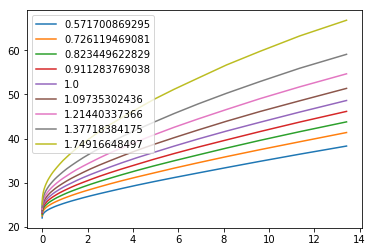

In [7]:
for i in range(0,9):
    plt.plot(kvec,V[i],label=str(z_grid[i]))
plt.legend()
plt.show()

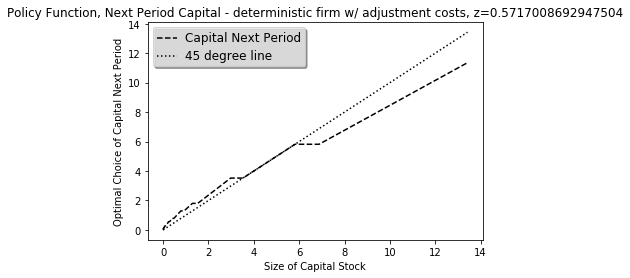

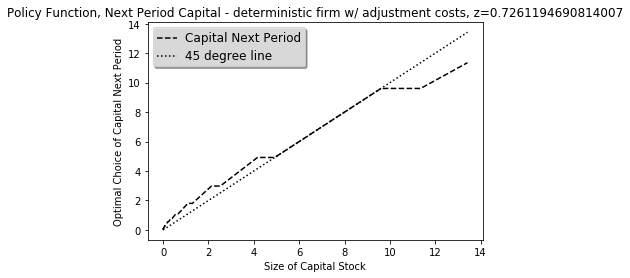

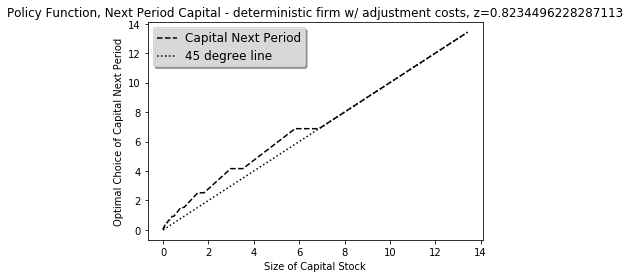

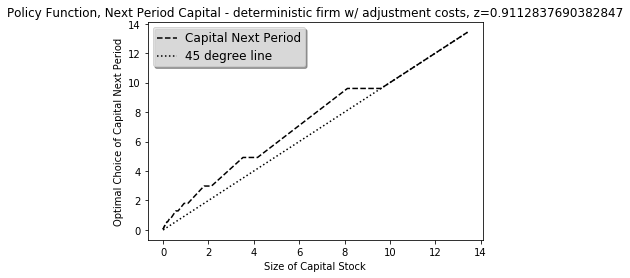

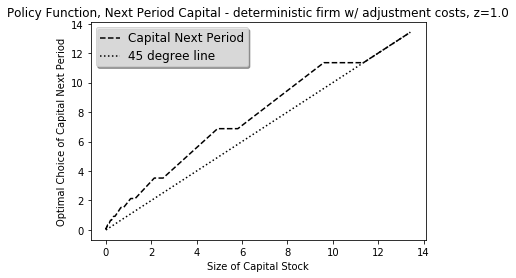

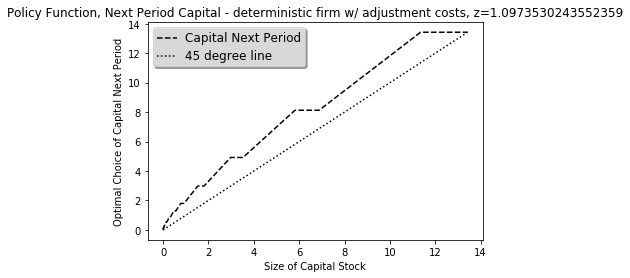

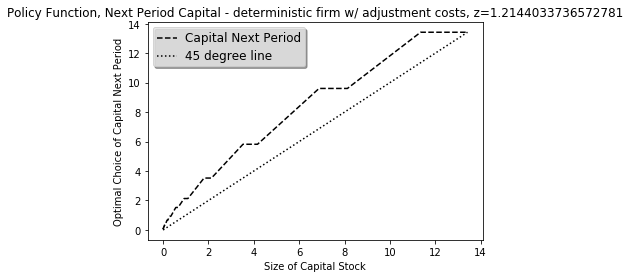

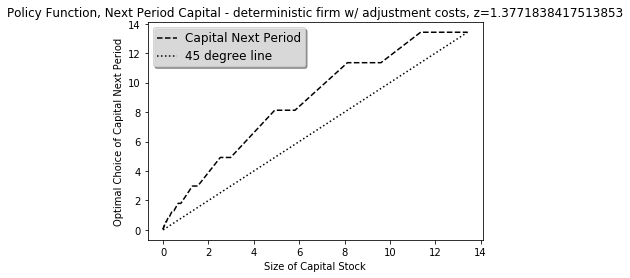

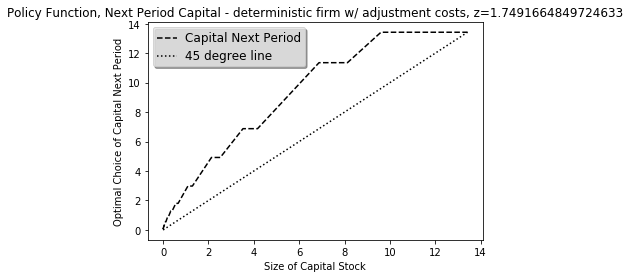

In [26]:
# Plot optimal capital stock rule as a function of firm size
for i in range(len(z_grid)):
    fig, ax = plt.subplots()
    ax.plot(kvec, kvec[PF[i].astype(np.int)], 'k--', label='Capital Next Period')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
              'adjustment costs, z={}'.format(z_grid[i]))